In [1]:
"""
Name: Amit Prakash
"""

'\nName: Amit Prakash\n'

# Data Preprocessing/Decision Tree

You will be doing Decision Tree classification on the Diabetes dataset.
We will also be using data preprocessing to test ways to improve the classifier.


## Import all necessary libraries

In [2]:
! pip install pandas scikit-learn --user
# you should be familiar with numpy, pandas and matplotlib from HW0
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# we're using the Diabetes dataset from sklearn.datasets
from sklearn import datasets

# we will also be using the PCA library from scikit learn for this exercise
from sklearn.decomposition import PCA

# we will use the StandardScaler method to z-score normalize our data
from sklearn.preprocessing import StandardScaler

# Remember you have to run this cell block before continuing!

In [3]:
# Load the Diabetes dataset from sklearn
diabetes_sk = datasets.load_diabetes(as_frame=True)
diabetes = pd.DataFrame(diabetes_sk.data, columns = diabetes_sk.feature_names)
diabetes["target"] = diabetes_sk.target
diabetes

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0
...,...,...,...,...,...,...,...,...,...,...,...
437,0.041708,0.050680,0.019662,0.059744,-0.005697,-0.002566,-0.028674,-0.002592,0.031193,0.007207,178.0
438,-0.005515,0.050680,-0.015906,-0.067642,0.049341,0.079165,-0.028674,0.034309,-0.018114,0.044485,104.0
439,0.041708,0.050680,-0.015906,0.017293,-0.037344,-0.013840,-0.024993,-0.011080,-0.046883,0.015491,132.0
440,-0.045472,-0.044642,0.039062,0.001215,0.016318,0.015283,-0.028674,0.026560,0.044529,-0.025930,220.0


## 1. Equal-width discretization

**Why discretize?**: As you can see, this dataset set has a *continuous* target variable (`target`), but decision trees are a type of *classifier*, which predicts a discrete (not continuous) target variable. Therefore, we need to discretize our target variable first.

To find out the appropriate discretization method for our data, we can start by plotting a histogram of our target values. Run the following code:

(array([38., 80., 68., 62., 50., 41., 38., 42., 17.,  6.]),
 array([ 25. ,  57.1,  89.2, 121.3, 153.4, 185.5, 217.6, 249.7, 281.8,
        313.9, 346. ]),
 <BarContainer object of 10 artists>)

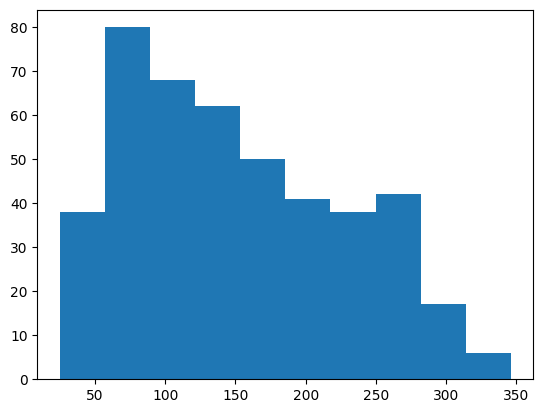

In [4]:
plt.hist(diabetes.target)

Looking at the histogram, there is no obvious split point. One option is to simply split the data into 2 bins using equal-width binning. In other words, after conducting equal-width binning on our target values, we will only have two values for our target (0 and 1). 

In the following exercises, you will be writing code to discretize a defined numpy vector into equal-width bins. The $n$ bins should all be of size $(max - min) / n$. If a value falls directly on a break, you should put it in the higher bin.

In [5]:
def equal_width(v, n):
    """
    Input: v: the vector to be discretized (np.array).
           n: is the number of equal-width bins (intervals) for discretization.
    Output: an np.array of the same length as v, where each item indicates the
            bin number (int value) of the corresponding item in v, starting at 0 for the
            first bin.
    Allowed Libraries: pandas and numpy. 
    """
    assert n > 0
    
   # get the bin size of the np.array
    bin_size = (np.max(v) - np.min(v)) / n
    
    # Create an empty np.array of length v to store the bin number for each value in v
    bin_array = np.zeros(len(v), dtype = int)
    
    # Iterate over the values in v
    for i, val in enumerate(v):
        # Example: (4 - 2) = 2 -> 2 // 7 = 0
        bin_index = int((val - np.min(v)) // bin_size)
        # Make sure the bin index is not greater than n - 1
        if bin_index == n:
            bin_index = n - 1
        bin_array[i] = bin_index
    
    return bin_array
    

In [6]:
# Test your function!
v = np.array([1, 6, 13, 40, 56, 7, 23, 43])
# Bin size should be 11 = (56-1)/5, so we get [1-12), [12, 23), etc.
count = equal_width(v, 5)
count

array([0, 0, 1, 3, 4, 0, 2, 3])

In [7]:
v = np.array([1, 6, 13, 40, 56, 7, 23, 43])
# Note, the "or" here is to support the original, incorrect test cases
assert np.array_equal(equal_width(v, 5), np.array([0, 0, 1, 3, 4, 0, 2, 3]))
assert np.array_equal(equal_width(v, 3), np.array([0, 0, 0, 2, 2, 0, 1, 2]))
assert np.array_equal(equal_width(v, 1), np.array([0, 0, 0, 0, 0, 0, 0, 0]))

The code below creates a copy of our `diabetes` dataframe called `diabetes_disc`. Now use the `equal_width` function to discretize the `target` attribute (i.e. replace it with a binary attribute).

In [8]:
diabetes_disc = diabetes.copy()
diabetes_disc["target"] = equal_width(diabetes_disc["target"], 2)

In [9]:
# Check how many of each value we now have (0 = low risk; 1 = high risk)
diabetes_disc["target"].value_counts()

target
0    298
1    144
Name: count, dtype: int64

In [10]:
# Public tests to ensure you correctly discretized the dataset
assert(diabetes_disc["target"].value_counts()[0] == 298)
assert(diabetes_disc["target"].value_counts()[1] == 144)

## 2. Stratified sampling

The number of data points belonging to each class is different (twice as many 0s as 1s). This is called an **imbalanced dataset**. In general, that's not a problem, and we will learn how to evaluate classifiers on imbalanced data. However, for now we will use the accuracy score as an evaluation metric, which can be misleading on imbalanced data (e.g. if I always guess 0, I'll have ~66% accuracy).

To address this, let's use stratified sampling to ensure that we have no more of one class than the other.

In this part, you will be writing code to do stratified sampling. Create a stratrified sample of the `diabetes_disc` dataset, with 40 objects, that has an equal number of each **target** value (0 and 1).

**Store it in the variable `stratified_diabetes`**.

**Hint**: You should read about the [split-apply-combine](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) coding pattern in Pandas before starting this problem! In particular pay attention to the following:
* [Splitting an object into groups](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#splitting-an-object-into-groups)
* [Transformation](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html#transformation)


In [11]:
stratified_diabetes = diabetes_disc.groupby("target")
# Concatenates the sampled stratified_diabetes of 40
stratified_diabetes = pd.concat(group.sample(20, replace = False) for name, group in stratified_diabetes)

In [12]:
# View your output
stratified_diabetes

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
301,-0.001882,0.050680,-0.024529,0.052858,0.027326,0.030001,0.030232,-0.002592,-0.021395,0.036201,0
214,0.030811,-0.044642,-0.033151,-0.022885,-0.046975,-0.081167,0.103865,-0.076395,-0.039809,-0.054925,0
175,0.067136,-0.044642,-0.038540,-0.026328,-0.031840,-0.026366,0.008142,-0.039493,-0.027129,0.003064,0
188,0.005383,-0.044642,-0.002973,0.049415,0.074108,0.070710,0.044958,-0.002592,-0.001496,-0.009362,0
411,0.005383,-0.044642,0.058463,-0.043542,-0.073119,-0.072399,0.019187,-0.076395,-0.051404,-0.025930,0
33,0.030811,-0.044642,-0.050396,-0.002228,-0.044223,-0.089935,0.118591,-0.076395,-0.018114,0.003064,0
73,0.012648,0.050680,-0.020218,-0.002228,0.038334,0.053174,-0.006584,0.034309,-0.005142,-0.009362,0
178,0.041708,-0.044642,-0.008362,-0.026328,0.024574,0.016222,0.070730,-0.039493,-0.048359,-0.030072,0
74,0.012648,0.050680,0.002417,0.056301,0.027326,0.017162,0.041277,-0.039493,0.003709,0.073480,0
393,-0.074533,-0.044642,-0.046085,-0.043542,-0.029088,-0.023234,0.015505,-0.039493,-0.039809,-0.021788,0


In [13]:
# Public tests for random sampling
np.testing.assert_equal(sum(stratified_diabetes["target"] == 0),20)
np.testing.assert_equal(sum(stratified_diabetes["target"] == 1),20)
assert any([(diabetes_disc.iloc[i,:] == stratified_diabetes.iloc[0,:]).all() for i in diabetes_disc.index])

Now, use the same function you defined aboved to create a *balanced* dataset called `diabetes_sample` with 250 total instances, 125 of each class (target = 1 or 0).

In [14]:
# Use this seed to ensure that your sample is consistent
diabetes_sample = diabetes_disc.groupby("target")
# Concatenates the sampled, balanced diabetes_sample of 250
diabetes_sample = pd.concat(group.sample(125, replace = True) for name, group in diabetes_sample)

In [15]:
# You should have 125 * 2 = 250 rows
assert(diabetes_sample.shape[0] == 250)
assert(sum(diabetes_sample.target == 0) == 125)
assert(sum(diabetes_sample.target == 1) == 125)

## 3. Decision Trees

Now we are going to classify the low versus high risk diabetes cases (the zeros versus the ones) with Decision Trees.

You can perform classification using a DecisionTree in python using the scikit-learn library. 

Take a look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier) to get a clear understanding of all function arguments.

Given below is a simple toy example for you to learn how to use the DecisionTreeClassifier.

In [16]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
# we will use the MinMaxScaler method to scale our data
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# To make sure the data remains consistent in the following steps, 
# we load a prepared version of diabetes_sample.
# Make sure you run this code for the test cases to work
diabetes_sample = pd.read_csv('https://drive.google.com/uc?id=17eI7youTlztjFEvidAlDj7f1QnShFJ9H')
diabetes_sample 

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,target
0,0.012648,-0.044642,-0.025607,-0.040099,-0.030464,-0.045155,0.078093,-0.076395,-0.072128,0.011349,0
1,-0.060003,0.050680,0.015350,-0.019442,0.036958,0.048164,0.019187,-0.002592,-0.030751,-0.001078,0
2,-0.027310,0.050680,-0.023451,-0.015999,0.013567,0.012778,0.026550,-0.002592,-0.010904,-0.021788,0
3,0.067136,0.050680,-0.014828,0.058596,-0.059359,-0.034508,-0.061809,0.012906,-0.005145,0.048628,0
4,0.070769,0.050680,-0.030996,0.021872,-0.037344,-0.047034,0.033914,-0.039493,-0.014956,-0.001078,0
...,...,...,...,...,...,...,...,...,...,...,...
245,0.067136,0.050680,-0.006206,0.063187,-0.042848,-0.095885,0.052322,-0.076395,0.059424,0.052770,1
246,-0.041840,-0.044642,0.128521,0.063187,-0.033216,-0.032629,0.011824,-0.039493,-0.015998,-0.050783,1
247,0.009016,-0.044642,-0.012673,0.028758,-0.018080,-0.005072,-0.047082,0.034309,0.023375,-0.005220,1
248,0.034443,0.050680,-0.009439,0.059744,-0.035968,-0.007577,-0.076536,0.071210,0.011008,-0.021788,1


In the first step, we will split our data into train and test subsets. To get more insight into the function we are using here, take a look at [this tutorial.](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)

* `X_train` is the features (independent variables) of the training dataset.
* `y_train` is the target (dependent) variable of the training dataset.
* `X_test` is the features (independent variables) of the test dataset.
* `y_test` is the target (dependent) variable of the test dataset.

In [17]:
X_train, X_test, y_train, y_test = train_test_split(diabetes_sample.drop("target", axis=1), diabetes_sample.target, test_size = 0.33, random_state = 2022)

In [18]:
# Inspect X_train
X_train

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
4,0.070769,0.050680,-0.030996,0.021872,-0.037344,-0.047034,0.033914,-0.039493,-0.014956,-0.001078
120,0.009016,0.050680,-0.005128,-0.064199,0.069981,0.083863,-0.039719,0.071210,0.039540,0.019633
31,-0.005515,0.050680,-0.011595,0.011544,-0.022208,-0.015406,-0.021311,-0.002592,0.011008,0.069338
111,-0.027310,0.050680,-0.015906,-0.029771,0.003935,-0.000688,0.041277,-0.039493,-0.023645,0.011349
117,-0.027310,-0.044642,-0.018062,-0.040099,-0.002945,-0.011335,0.037595,-0.039493,-0.008944,-0.054925
...,...,...,...,...,...,...,...,...,...,...
177,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
112,-0.041840,-0.044642,0.041218,-0.026328,-0.031840,-0.030437,-0.036038,0.002943,0.033657,-0.017646
173,0.059871,0.050680,0.022895,0.049415,0.016318,0.011838,-0.013948,-0.002592,0.039540,0.019633
220,0.096197,-0.044642,0.051996,0.079254,0.054845,0.036577,-0.076536,0.141322,0.098646,0.061054


In [19]:
# Inspect y_train
y_train

4      0
120    0
31     0
111    0
117    0
      ..
177    1
112    0
173    1
220    1
125    1
Name: target, Length: 167, dtype: int64

Now implement a decision tree function below to do the following:

1. Train a decision tree model with the **training datasets** created above (using **gini index** as the criteria and **random_state = 1234** in order to keep consistency).
2. Use the model trained from step 1 to make predictions on the **test data** created above

**Store the predictions in the variable `dtree_predictions`**. 

In [20]:
from sklearn import tree

dtree_model = tree.DecisionTreeClassifier(criterion = 'gini', random_state = 1234)
dtree_model = dtree_model.fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)

# Code above as a function
def dtree(X_train, y_train, X_test, criterion_string, random_state_num):
    dtree_model = tree.DecisionTreeClassifier(criterion = criterion_string, random_state = random_state_num)
    dtree_model = dtree_model.fit(X_train, y_train)
    dtree_predictions = dtree_model.predict(X_test)
    return dtree_predictions

In [21]:
# Test your result!
dtree_predictions

array([1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1], dtype=int64)

In this step, you will look into the accuracy score of the decision tree predictions. In other words, you would compare the predictions of the decision tree with the actual test labels you have in the testing set. 

For more documentation, take a look at [this article.](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html)

In [22]:
accuracy_score(dtree_predictions, y_test)

0.6746987951807228

In [23]:
# Public tests for dtree
np.testing.assert_almost_equal(
    accuracy_score(dtree(X_train, y_train, X_test, 'gini', 1234),
                   y_test),
    0.6746987951807228
)

## 4. Feature Selection

In this problem, you will see if feature selection can improve the accuracy of your classifier!

We do feature selection to remove unnecessary features, and also to see which features are most useful for prediction. You could imagine predicting diabetes progression would be easier if we know which features are relevant for doing so.

In the function below, you will implement a feature selection aglorithm, which selects the $k$ best features according to some measure. In this case we'll use the  [ANOVA F-value](https://www.statisticshowto.com/probability-and-statistics/f-statistic-value-test/), which is a measure of the linear relationship between each feature and the target variable (just like correlation).

**Note**: Remember, we can't peek at the test data, even during feature selection (if we knew what features were useful on the test dataset, that would be unrealistic). Therefore, it is important that you fit the the feature selction function **ONLY** on the *training* set. One the feature selector is fit (i.e. figures out which features to keep), you can use it to transform both training and testing dataset (`X_train` and `X_test`), i.e. remove the unneeded features.

**HINT**: Feature selection is performed using [SelectKBest function](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectKBest.html) with [ANOVA F-value](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.f_classif.html#sklearn.feature_selection.f_classif) function.

**HINT**: In python you can return multiple values, separated by commas, e.g. `return 1, 2, 3`.

In [24]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

def feature_selection(X_train, y_train, X_test, k = 7):
    """
     Input:
          x_train: A numpy array of shape (n_training_rows, n_attributes) where n_training_rows refers to 
          the number of rows in your training dataset and n_attributes refers to the number of attributes. 
          y_train: A numpy array of shape (n_training_rows, ) containing the class labels for each row in your 
          training dataset.
          x_test: A numpy array of shape (n_testing_rows, n_attributes) where n_testing_rows refers to the number 
          of rows in your testing dataset and n_attributes refers to the number of attributes. 
          k: number of features to select.
    Output:
          fs: The fit feature selector
          X_train_selected: The transformed training set, with features selected. 
                            The result should be a numpy array of shape (n_training_rows, k).
          X_test_selected: The transformed testing set, with features selected.
    
    Allowed Libraries: sklearn
    """
    feature_select = SelectKBest(score_func = f_classif, k = k)
    X_train_selected = feature_select.fit_transform(X_train, y_train)
    X_test_selected = feature_select.transform(X_test)

    return feature_select, X_train_selected, X_test_selected

In [25]:
# Test your function

fs,X_train_selected,X_test_selected = feature_selection(X_train, y_train, X_test, 7)

# Check the score for each individual feature (i.e. how important is each feature)
print(fs.scores_)

# Check whether acheived seven best attributes for both training and testing set
print(X_train_selected.shape)
print(X_test_selected.shape)

[10.24406375  0.32412959 79.97760873 52.22714048  7.98568598  4.59688789
 22.28757342 28.12717132 53.05316779 24.09618915]
(167, 7)
(83, 7)


In [26]:
# Let's get the name of the selected features

print("Original features are: \n" + str(X_train.columns.values))

print("Selected best feautures are: \n" + str(X_train.columns.values[fs.get_support()]))

Original features are: 
['age' 'sex' 'bmi' 'bp' 's1' 's2' 's3' 's4' 's5' 's6']
Selected best feautures are: 
['age' 'bmi' 'bp' 's3' 's4' 's5' 's6']


In [27]:
# Public tests for feature_selection
fs, selected_train, selected_test = feature_selection(X_train, y_train, X_test, 5)
assert (selected_train.shape[1] == 5)
assert (selected_test.shape[1] == 5)
assert ('s1' not in X_train.columns.values[fs.get_support()])
assert ('bmi' in X_train.columns.values[fs.get_support()])

## 5. Feature Transformation

Now we will combine feature selection with normalization into a *pipeline*, and test whether it improves our mode.

In some cases, you would want to perform certain feature transformations such as z-score normalization.

Take a look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) to get a clear understanding of all function argumetns for z-score normalization.

Given below is a simple example for you to learn how to use z-score normalization and combine it with other data processing procedures. 

In [28]:
# let's use a toy dataset to demonstrate z-score normalization. 
# We are using the iris dataset from sklearn.datasets as our toy dataset.

# First load the data
toy_dataset = datasets.load_iris(as_frame=True).data

# To emulate an actual model learning process, we split the data set into trainining and testing set
toy_train, toy_test = train_test_split(toy_dataset, test_size = 0.33)

# Here we use StandardScaler class from sklearn to normalize
toy_norm_train = StandardScaler().fit(toy_train).transform(toy_train)

# Notice here we use the training set to fit the StandardScaler, i.e. compute the mean and standard deviation,
# and use it to normalize testing set, just like with feature selection, above.
# This is because in real-world deployment case, you very likely won't know the parameter of unseen data distribution
# (testing set). So a normal approach is to use distribution parameters estimated from training set to transform
# unseen data.
toy_norm_test = StandardScaler().fit(toy_train).transform(toy_test)


In [29]:
# Note the means are all different
toy_train.mean()

sepal length (cm)    5.840
sepal width (cm)     3.016
petal length (cm)    3.797
petal width (cm)     1.206
dtype: float64

In [30]:
# And the standard deviations vary
toy_train.std()

sepal length (cm)    0.845308
sepal width (cm)     0.442609
petal length (cm)    1.752081
petal width (cm)     0.751137
dtype: float64

In [31]:
# Now column means are all near 0
print(toy_norm_train[:,0].mean())
print(toy_norm_train[:,1].mean())
print(toy_norm_train[:,2].mean())
print(toy_norm_train[:,3].mean())

2.1149748619109232e-16
-2.1038726316646716e-15
4.0023540037736893e-16
-2.248201624865942e-16


In [32]:
# Now and standard deviations are near 1
print(toy_norm_train[:,0].std())
print(toy_norm_train[:,1].std())
print(toy_norm_train[:,2].std())
print(toy_norm_train[:,3].std())

1.0
1.0000000000000002
1.0
1.0


You will build a pipeline that perform both feature selection (using your earlier function) and z-score normalization.

In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
def normalize_feature_select(X_train, y_train, X_test, k = 7):
    """
    You will build a pipeline that perform the following steps:
        1. z-score normalize the x_train and x_target using x_train.
        2. perform feature selection.
    
    Your inputs and outputs are as shown below:
    
    Input:
          x_train: A numpy array of shape (n_training_rows, n_attributes) where n_training_rows refers to 
              the number of rows in your training dataset and n_attributes refers to the number of attributes. 
          y_train: A numpy array of shape (n_training_rows, ) containing the class labels for each row in your 
              training dataset.
          x_test: A numpy array of shape (n_test_rows, n_attributes) where n_test_rows refers to the number 
              of rows in your target dataset and n_attributes refers to the number of attributes. 
          k: number of features to select.
    Output:
          x_train_selected: A numpy array of shape (n_train_rows, n_selected_attributes) containing 
              z-score normalized data from x_train with selected features only. 
              n_selected_attributes is the number of selected features.
          x_test_selected: A numpy array of shape (n_test_rows, n_selected_attributes) containing 
              z-score normalized data from x_test with selected features only. 
              n_selected_attributes is the number of selected features.
          
    Allowed Libraries: sklearn
    """
    
    std_scaler = StandardScaler()
    x_train_selected = std_scaler.fit_transform(X_train)
    x_test_selected = std_scaler.transform(X_test)
    
    feature_select = SelectKBest(f_classif, k = k)
    feature_select.fit(x_train_selected, y_train)
    
    x_train_selected = feature_select.transform(x_train_selected)
    x_test_selected = feature_select.transform(x_test_selected)
    
    return x_train_selected, x_test_selected


In [34]:
#Test your code!
X_norm_selected_train, X_norm_selected_test = normalize_feature_select(X_train, y_train, X_test, k = 7)

# Mean of attribute 0 should be 0
print(X_norm_selected_train[:,0].mean())
# Standard deviation of attriute 0 should be 1
print(X_norm_selected_train[:,0].std())

0.0
1.0


In [35]:
# Public tests for feature_selection
selected_train, selected_test = normalize_feature_select(X_train, y_train, X_test, 5)
assert (selected_train.shape[1] == 5)
assert (selected_test.shape[1] == 5)
for i in range(0, 5):
    np.testing.assert_almost_equal(X_norm_selected_train[:,i].mean(), 0)
    np.testing.assert_almost_equal(X_norm_selected_train[:,i].std(), 1)
    # test set shouldn't be perfectly centered or scaled
    assert X_norm_selected_test[:,i].mean() != 0
    assert X_norm_selected_test[:,i].std() != 1

Now is the moment of truth - did the decision tree improve our classifier? Let's compare.

In [36]:
# First, let's recreate the original decision tree.
dtree_predictions = dtree(X_train, y_train, X_test, 'gini', 1234) # Random see for consistency
accuracy_score(dtree_predictions, y_test)

0.6746987951807228

In [37]:
# Next the normalized, feature selected tree
dtree_norm_selected_predictions = dtree(X_norm_selected_train, y_train, X_norm_selected_test, 'gini', 1234)
accuracy_score(dtree_norm_selected_predictions, y_test)

0.6867469879518072

Which features did better - the originals or the normalized, feature selected ones? How much of a difference did preprocessing make? Based on what you know about decision trees, z-score normalization and feature selection, why do you think this was the case? Answer below in 2-3 sentences.

The normalized, selected features performed marginally better than the original features. With a difference which was around 1.2% diffent, this could be due to the fact that the dataset may not have had much noise to remove during preprocessing, resulting in a small increase in performance. There was no significant difference since decision trees always optimizes based on information gain, which naturally acts like feature selection. 

## 6. PCA

## Examples

You can perform PCA in python using the scikit-learn library. Take a look at the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) to get a clear understanding of all function arguments.

Given below is a simple toy example for you to learn how to use PCA. 

In [38]:
# let's use a toy dataset to demonstrate PCA. We are using the iris dataset from sklearn.datasets as our toy dataset.
# We will apply PCA on it and extract the first two principal components. 
# While there are ways to directly extract the principal components using the sklearn methods, for the purpose 
# of this exercise, we will first extract the eigen vectors and then calculate the principal components from these eigen vectors. 

# first, load and z-score normalize the data
toy_dataset_sk = datasets.load_iris(as_frame=True)
toy_dataset = pd.DataFrame(StandardScaler().fit_transform(toy_dataset_sk.data), columns = toy_dataset_sk.feature_names)

# Display the dataset for your reference
# note that you can use the display() method to display your pandas dataframe in Jupyter
#display(toy_dataset)

# apply PCA on the toy dataset and extract the eigen vectors of the first two principal components
toy_pca = PCA(n_components = 2).fit(toy_dataset)
toy_eigen_vectors = toy_pca.components_

# now extract the first two principal components
# Recall from class material how to do this.  
# Take a look at matrix multiplication using numpy here: 
# https://numpy.org/doc/stable/reference/generated/numpy.matmul.html
toy_principal_components = np.matmul(toy_dataset.values , toy_eigen_vectors.T)


In [39]:
# Explore the outputs of the eigen vectors and principal components to gain a better understanding
# Explore other outputs...
print(toy_eigen_vectors.T.shape)
print(toy_dataset.values.shape)

(4, 2)
(150, 4)


### 6.1: Extracting Eigen Vectors

In [40]:
# Problem 1
def principal_component_analysis(data, n_components):
    """
    Input: 
          data: Data frame with M numeric attributes.
          n_components: the number of principal components to calculate 
                        (e.g. 2 for two principal components)
    Output:
          a numpy array of floating point numbers of shape (n_components, M), 
          containing the first n_components eigen vectors.
            
    """
    pca = PCA(n_components = n_components)
    data_transformed = pca.fit_transform(data)
    eigen_vectors = pca.components_
    return eigen_vectors

In [41]:
# Test your function!
# note that you can convert your pandas data frame into a numpy matrix by using the dataframe.values property
eigen_vectors = principal_component_analysis(X_train, 2)
# Each of the 2 eigen vectors should have a value/weight for each of the original 13 attributes
eigen_vectors.shape

(2, 10)

In [42]:
assert principal_component_analysis(X_train, 2).shape == (2, 10)
np.testing.assert_almost_equal(
    principal_component_analysis(X_train, 2)[0, :], 
    np.array(
        [ 0.1999915,  0.216183 ,  0.3047298,  0.3221714,  0.3273805,
        0.3277386, -0.276162 ,  0.4368469,  0.3730398,  0.3094571]
    )
)

### 6.2. Calculating Principal Components from Eigen Vectors

In [43]:
# Problem 2
def principal_component_calculation(data, component_weights):
    """
    Input: 
          data: A data frame with N rows and M numeric attributes (e.g. 178 x 13). 
          component_weights: a numpy array of shape (n_components, M) containing the weights (eigen vector) of 
              the first n_components principal components 
              (i.e. the output from running principal_component_analysis from problem 1)
    Output:
          a pandas dataframe of shape (N, n_components) ontaining the n_components principal components,
          calculated for each of the N rows in data.
    Hint: Can you solve this with matrix multiplication? Check out the np.matmul function.
    """
    return np.matmul(data, component_weights.T)


In [44]:
# Test your function

# note that eigen_vectors are the eigen vectors you calculated earlier using principal_component_analysis. 
# We're calculating it again here for ease of use
eigen_vectors = principal_component_analysis(X_train, 2)
principal_component_values = principal_component_calculation(X_train, eigen_vectors)
print(f'Principal components are = {principal_component_values} and their shape is {principal_component_values.shape}')

Principal components are =             0         1
4   -0.037461  0.074741
120  0.103811 -0.087356
31   0.028036  0.048609
111 -0.041841 -0.016324
117 -0.086183 -0.036811
..        ...       ...
177 -0.000116 -0.068271
112 -0.016007  0.022502
173  0.078594  0.044191
220  0.219474  0.028141
125  0.004838 -0.024858

[167 rows x 2 columns] and their shape is (167, 2)


In [45]:
test_eigen_vectors = principal_component_analysis(X_train, 2)
test_pc = principal_component_calculation(X_train, test_eigen_vectors)
assert test_pc.shape == (X_train.shape[0], 2)
np.testing.assert_almost_equal(test_pc.iloc[0, :],[-0.0374607,  0.0747412])

### 6.3: Visualize your results

You've gained familiarity with matplotlib in HW0. Now use matplotlib to

a) generate a plot with the first principal component on x-axis, second principal component on y-axis. 

b) Assign color to each data point according to the target value. You can do this using the splitted y_train or y_test, depending on which set you are plotting.  

***Hint 1:*** Take a look at the [plt.scatter](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.scatter.html) function. Pay close attention to the 'c' variable. 

c) Name the x-axis as "PC1", y-axis as "PC2"

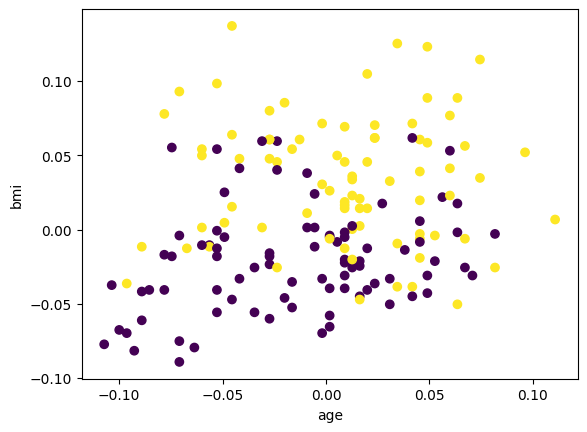

In [46]:
# This is an example of a scatter plot, using the bmi and age of participants
plt.scatter(X_train.iloc[:, 0], X_train.iloc[:, 2], c=y_train)
plt.xlabel(X_train.columns[0])
plt.ylabel(X_train.columns[2])
plt.show()

# How well does this plot separate the 2 different classes?

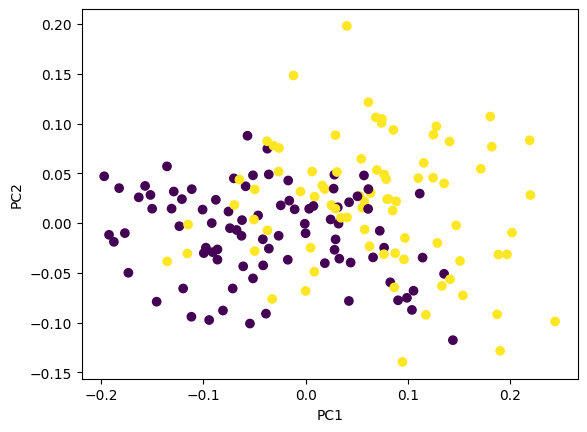

In [47]:
# Problem 3 (see question above)

# recalculating eigen vectors and principal components for ease of use
eigen_vectors = principal_component_analysis(X_train, 2)
principal_component_values = principal_component_calculation(X_train, eigen_vectors)
plt.scatter(principal_component_values.iloc[:, 0], principal_component_values.iloc[:, 1], c = y_train)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

Do the first 2 PCs separate the data better than the first 2 numeric attributes?

Yes, there is a more distinct separation between the two different PCs than the first 2 numeric attributes. The first plot has a more distinct mix of the data with more interaction between the attributes. Whereas, the second plot shows a more distinct separation between PC1 and PC2 with less interaction between PC1 and PC2.